In [1]:
from __future__ import annotations

from enum import Enum
from collections.abc import Sequence

from qiskit import QuantumCircuit, transpile
from qiskit.circuit.library import EfficientSU2
from qiskit.providers import Backend
from qiskit.providers.fake_provider import FakeHanoiV2 as FakeHanoi

from circuit_knitting.cutting.qpd import decompose_qpd_instructions
from circuit_knitting.cutting import cut_gates

In [2]:
def evaluate_cuts(
    circuit: QuantumCircuit,
    backend: Backend,
    gate_ids: Sequence[int] | None = None,
    initial_layout: Sequence[int] | None = None,
) -> list[tuple[int, int]]:
    circuit = circuit.copy()
    supported_gates = {"rxx", "ryy", "rzz", "crx", "cry", "crz", "cx", "cz"}
    
    input_depth = transpile(circuit, backend=backend, initial_layout=initial_layout).depth()
    
    if gate_ids is None:
        gate_ids = list(range(len(circuit.data)))
        
    cut_scores = []
    for idx in gate_ids:
        if circuit[idx].operation.name not in supported_gates:
            continue
        inst_to_check = circuit[idx]
        del circuit.data[idx]
        cut_score = input_depth - transpile(circuit, backend=backend, initial_layout=initial_layout).depth()
        cut_scores.append((idx, cut_score))
        circuit.data.insert(idx, inst_to_check)
        
    return sorted(cut_scores, key=lambda x: x[1], reverse=True)
        

### Score each gate by the depth reduction resulting from removing it

In [3]:
backend = FakeHanoi()
circuit = EfficientSU2(8, entanglement='sca', reps=4).decompose()
circuit.draw('mpl', scale=0.6)
cut_scores = evaluate_cuts(circuit, backend)

### Get the top N cuts, remove them, and observe the depth reduction gained

In [4]:
NUM_CUTS = 5

cut_indices = [cut_scores[i][0] for i in range(NUM_CUTS)]
qpd_circuit, bases = cut_gates(circuit, cut_indices)


qpd_circuit.draw('mpl')
for idx in cut_indices:
    qpd_circuit[idx].operation.basis_id = 0    
    inst = qpd_circuit[idx].operation

qpd_circuit_dx = decompose_qpd_instructions(qpd_circuit, [[idx] for idx in cut_indices])

# Transpile the decomposed circuit to the same layout
#transpiled_qpd_circuit = transpile(qpd_circuit_dx, backend=backend)

#print(f"QPD subexperiment depth after transpile: {transpiled_qpd_circuit.depth()}")
#transpiled_qpd_circuit.draw("mpl", scale=0.8, idle_wires=False)

     ┌────────┐
q_0: ┤ cut_cx ├
     ├────────┤
q_1: ┤ cut_cx ├
     └────────┘
   ┌──────────────┐
q: ┤ R(θ[54],π/2) ├
   └──────────────┘


IndexError: list index out of range

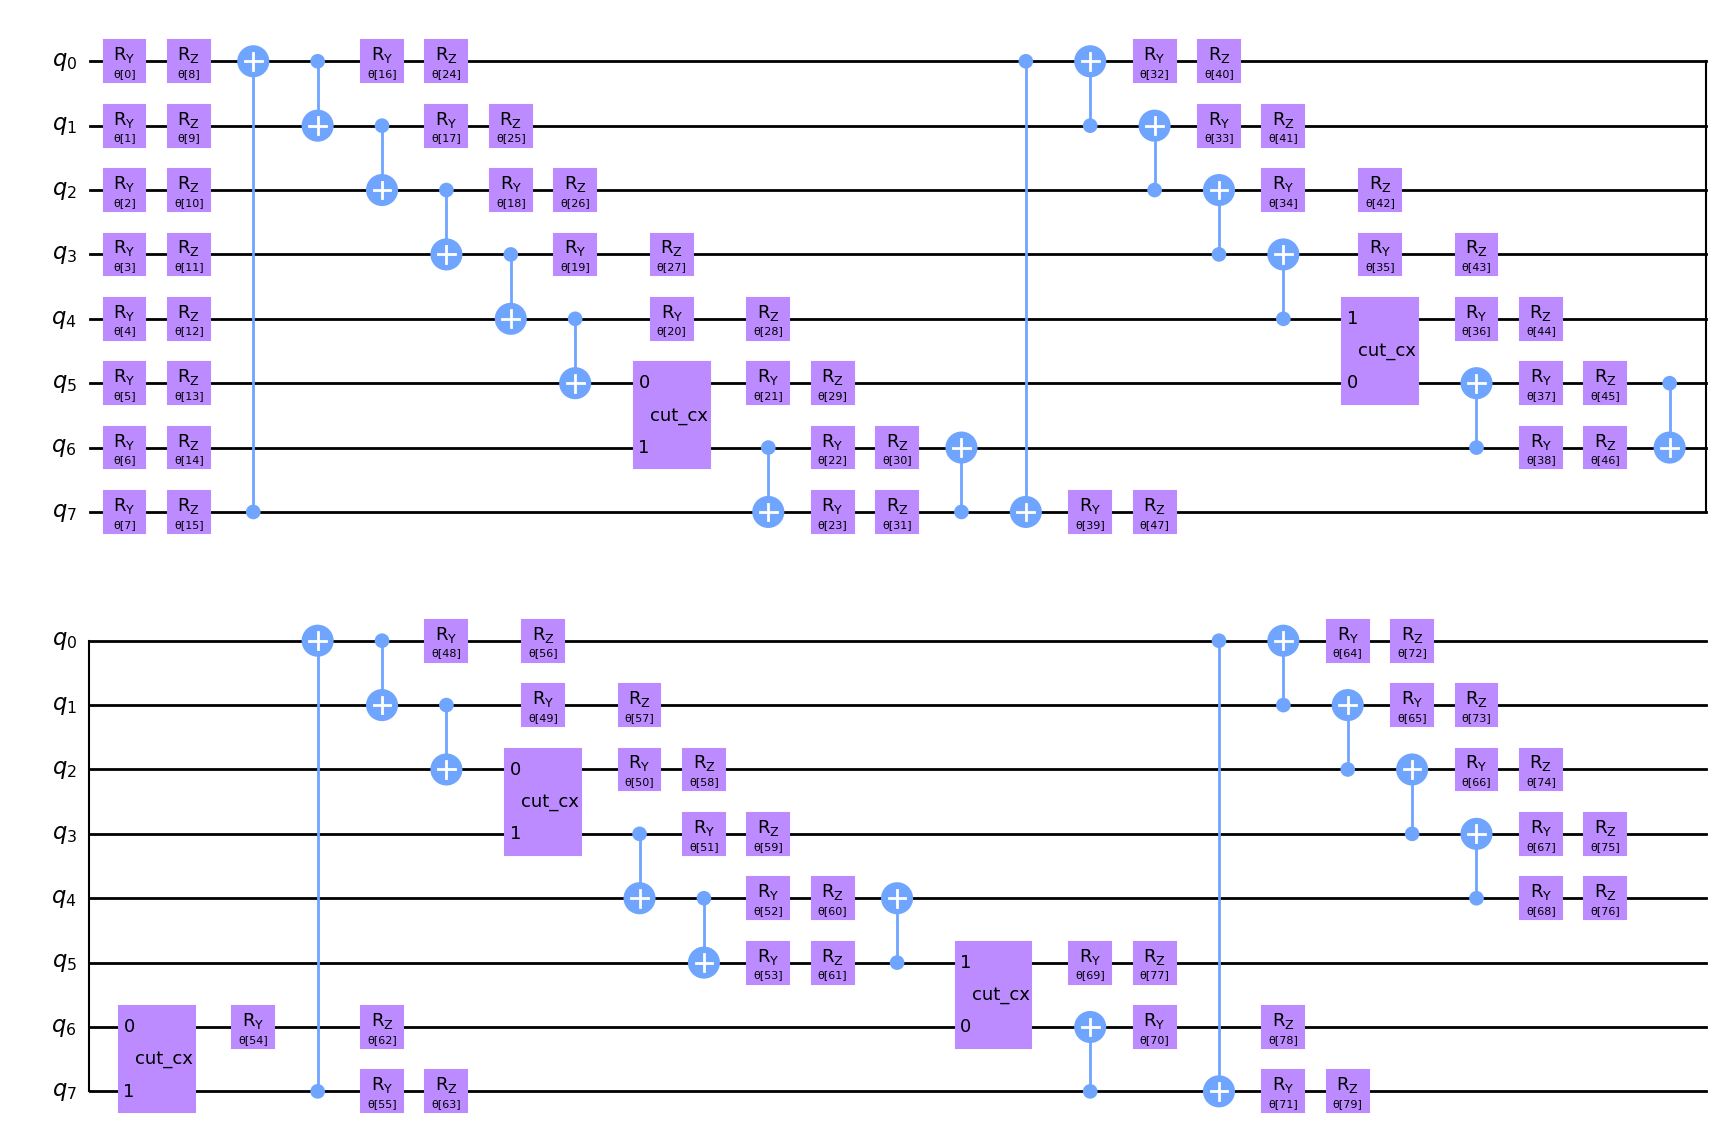

In [5]:
qpd_circuit.draw('mpl')

In [56]:
import random

random.randint(0, 5)

5